# 학습 목표
- 데이터 수집
- 이미지 전처리(ImageDataGenerator)
    - 이미지 크기 동일하게 변환
    - 이미지 라벨링 (폴더의 이름으로 라벨링, 알파벳으로 0부터 라벨링)
    - 회귀/이진/다진분류 설정
    - 배치 사이즈 : 전체 데이터를 올리면 메모리 문제

- 신경망 설계/학습/시각화/예측

- 증강 (augmentation) : 과적합을 줄이기 우해서 데이터를 증가시키는 방법
- 증강된 데이터로 학습/시각화/예측

- 과적합 방지 방법 : BatchNormalization(), GlobalAveragePool2D()
- 전이학습 : VGG16 -> 특성추출, 미세조정(Fine-tuning)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,LeakyReLU,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

seed = 999
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import zipfile
# 압축을 풀 파일 설정
zip_file = zipfile.ZipFile("./data/Animal.zip","r")

# 압출을 현재폴더에 푼다
zip_file.extractall("./data")

# 객체를 닫아준다
zip_file.close()

In [3]:
import os

train_dir = "./data/train"
val_dir = "./data/val"
print("train:파일수 : ", len(os.listdir("./data/train/ELEPHANT")))
print("train:파일수 : ", len(os.listdir("./data/train/HORSE")))
print("train:파일수 : ", len(os.listdir("./data/train/LION")))
print("val:파일수 : ", len(os.listdir("./data/val/ELEPHANT")))
print("val:파일수 : ", len(os.listdir("./data/val/HORSE")))
print("val:파일수 : ", len(os.listdir("./data/val/LION")))

train:파일수 :  1000
train:파일수 :  1000
train:파일수 :  1000
val:파일수 :  300
val:파일수 :  300
val:파일수 :  300


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 정규화
datagen = ImageDataGenerator(rescale=1./255)

# 훈련데이터 전처리
# flow_from_directory() : 이미지 데이터를 폴더로부터 읽어온다.
# train_dir : 이미지 데이터가 있는 폴더명
# target_size : 이미지 크기를 맞춤
# batch_size : 훈련에 한번에 처리되는 데이터 수
# class_mode : 클래스의 수를 결정
#   - binary : 두개로 라벨링, 학습시에 자동 원핫인코딩
#   - categorical : 클래스 수로 라벨링, 자동 원핫인코딩
#   - sparse : 클래스 수로 라벨링, 원핫인코딩x -> compile에서 loss를 sparse_categorical_crossentropy사용
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical"
)
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical"
)

Found 2999 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [5]:
train_gen.class_indices, val_gen.class_indices

({'ELEPHANT': 0, 'HORSE': 1, 'LION': 2},
 {'ELEPHANT': 0, 'HORSE': 1, 'LION': 2})

- 신경망 설계

In [6]:
m1 = Sequential()
m1.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",
              input_shape=(150,150,3)))
m1.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
m1.add(MaxPooling2D(pool_size=(2,2)))

m1.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
m1.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
m1.add(MaxPooling2D(pool_size=(2,2)))

m1.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
m1.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
m1.add(MaxPooling2D(pool_size=(2,2)))

m1.add(Flatten())
m1.add(Dense(units=128,activation="relu"))
m1.add(Dense(units=3,activation="softmax"))
m1.summary()

c:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,973,923 (15.16 MB)

 Trainable params: 3,973,923 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# m1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
# h1 = m1.fit(train_gen,epochs=10,validation_data=val_gen)

In [8]:
plt.plot(h1.history["loss"],color='r',label="loss")
plt.plot(h1.history["val_loss"],color="orange",label="val_loss")
plt.legend()
plt.show()
plt.plot(h1.history["accuracy"],color='b',label="acc")
plt.plot(h1.history["val_accuracy"],color="black",label="val_accuracy")
plt.legend()
plt.show()

NameError: name 'h1' is not defined

# Augmentation (데이터 증식)
    - 회전, 이동, 확대, 축소, 밝기/채도 변환, 찌그러뜨림등을 이용해서 실제 이미지를 약간 변형해서 이미지 수를 늘리는 방법(생성형 AI를 활용해서 새로운 이미지를 생성하기도 함)
    - 데이터가 부족한 경우 간단하게 데이터를 늘려서 과적합 해결할 수 있다.
    - ImageDataGenerator가 배치 사이즈만큼 데이터를 신경망에 입력전에 증식을 시켜서 데이터를 입력 -> 데이터의 수는 증가하지 않음

    - 증식의 조건 : 기존의 데이터 특징을 유지할 수 있을만큼만 실행
    - 증식은 훈련데이터에만 적용해야한다. 

    -단점
        - 전처리하는 시간이 더 소요된다.(증식을 수행하는 시간 더 걸림)
        - 과적합은 줄어들지만 정확도는 감소 -> 학습 반복수를 증가 시켜주어야 한다.
        - 가짜는 가짜다. -> 학습중에 정확도의 변화가 심해짐
        - 증식으로 급격한 성능개선이 있지는 않다.
        - 원 데이터가 문제가 있다면(편향), 증식데이터에도 상속된다.

    
    


In [9]:
# 훈련데이터에만 증식 설정
datagen_tr = ImageDataGenerator(rescale=1./255,
                                rotation_range=20,# 20도 범위 내에서 시계/반시계방향으로 회전
                                width_shift_range=0.2,#20%만큼 좌우로 이동
                                height_shift_range=0.1, #10%만큼 상하로 이동,
                                shear_range=0.1, #10%만큼 기울임
                                zoom_range=0.1, # 10%만큼 확대/축소
                                fill_mode="nearest"
                                )

datagen_val = ImageDataGenerator(rescale=1./255)
train_gen2 = datagen_tr.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical"
)
val_gen2 = datagen_val.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical"
)

Found 2999 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [10]:
m2 = Sequential()
m2.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",
              input_shape=(150,150,3)))
m2.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
m2.add(MaxPooling2D(pool_size=(2,2)))

m2.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
m2.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
m2.add(MaxPooling2D(pool_size=(2,2)))

m2.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
m2.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
m2.add(MaxPooling2D(pool_size=(2,2)))

m2.add(Flatten())
m2.add(Dense(units=128,activation="relu"))
m2.add(Dense(units=3,activation="softmax"))
m2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,973,923 (15.16 MB)

 Trainable params: 3,973,923 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# m2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
# h2 = m2.fit(train_gen2,epochs=10,validation_data=val_gen2)

Epoch 1/10


c:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 400ms/step - accuracy: 0.3610 - loss: 1.0977 - val_accuracy: 0.5022 - val_loss: 1.0688
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 399ms/step - accuracy: 0.4845 - loss: 1.0046 - val_accuracy: 0.4933 - val_loss: 0.9512
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 395ms/step - accuracy: 0.5866 - loss: 0.9191 - val_accuracy: 0.5911 - val_loss: 0.8534
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 407ms/step - accuracy: 0.6069 - loss: 0.8579 - val_accuracy: 0.6744 - val_loss: 0.7482
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 392ms/step - accuracy: 0.6283 - loss: 0.8276 - val_accuracy: 0.6456 - val_loss: 0.7763
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 396ms/step - accuracy: 0.6673 - loss: 0.7625 - val_accuracy: 0.6622 - val_loss: 0.7608
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 401ms/step - accuracy: 0.6637 - loss: 0.7487 - val_accuracy: 0.6644 - val_loss: 0.7751
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 396ms/step - accuracy: 0.6732 - loss: 0.7407 - val

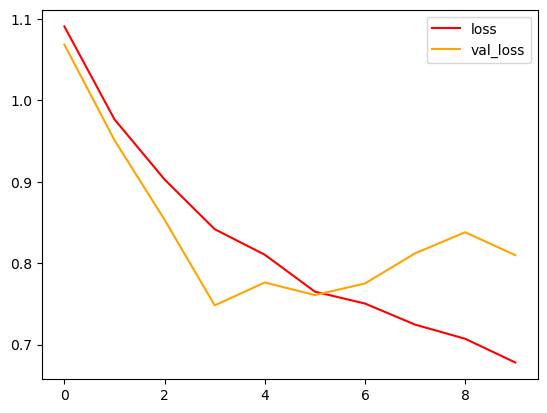

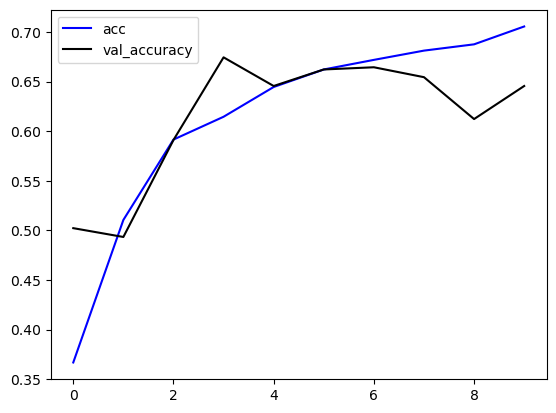

In [ ]:
plt.plot(h2.history["loss"],color='r',label="loss")
plt.plot(h2.history["val_loss"],color="orange",label="val_loss")
plt.legend()
plt.show()
plt.plot(h2.history["accuracy"],color='b',label="acc")
plt.plot(h2.history["val_accuracy"],color="black",label="val_accuracy")
plt.legend()
plt.show()

# 과적합 방지
    - BatchNormalization()
        - 각 퍼셉트론에 있는 w, b값들을 정규화하는 기능(평균 0, 분산1)
            -> 활성화 함수로 relu 쓸수 없다. LeakyRelu를 사용
        - CNN은 필터를 사용하기 때문에 w의 개수가 많아짐 -> w의 분산이 커질 수 있음
        - 위치는 Conv2D()와 Activation()층 사이에 배치
        -
    - GlobalAveragePooling2D()
        - CNN층과 Dense()층의 파라미터 수를 비슷하게 만듬

In [11]:
from keras.layers import BatchNormalization,GlobalAveragePooling2D,GlobalMaxPooling2D

In [12]:
m3 = Sequential()
# 특성 추출
# C + C+ A + BN + M(BN전에 활성화함수를 먼저 사용)
m3.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",
              input_shape=(150,150,3)))
m3.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
m3.add(BatchNormalization())
m3.add(MaxPooling2D(pool_size=(2,2)))

# C + C+ BN + A +M (BN뒤에 활성화 함수를 사용 - relu를 사용하면 안됨)
m3.add(Conv2D(filters=64, kernel_size=(3,3)))
m3.add(BatchNormalization())
m3.add(LeakyReLU())
m3.add(Conv2D(filters=64, kernel_size=(3,3)))
m3.add(BatchNormalization())
m3.add(LeakyReLU())
m3.add(MaxPooling2D(pool_size=(2,2)))

m3.add(Conv2D(filters=128, kernel_size=(3,3)))
m3.add(BatchNormalization())
m3.add(LeakyReLU())
m3.add(Conv2D(filters=128, kernel_size=(3,3)))
m3.add(BatchNormalization())
m3.add(LeakyReLU())
# m3.add(MaxPooling2D(pool_size=(2,2)))

# m3.add(Flatten())
# m3.add(Dense(units=128,activation="relu"))
m3.add(GlobalAveragePooling2D())
m3.add(Dense(units=3,activation="softmax"))
m3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 146, 146, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 71, 71, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 69, 69, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 69, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,059 (1.10 MB)

 Trainable params: 288,227 (1.10 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
# m3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
# h3 = m3.fit(train_gen,epochs=10,validation_data=val_gen)

# 전이학습
- 미리 학습된 우수한 모델을 가져와서 사용한 것
- 특성추출 방식 : 특성추출 모델 부분만 가져와서 사용하는 것
    - 단 가져온 특성추출부분은 학습 되지 않게 동결시켜주어야 함
- 파인튜닝 방식 : 가져온 특성추출모델의 마지막층만 학습하도록하여 분류기 모델과 잘 맞도록 조정하는 작업

In [13]:
# VGG16모델 가져오기
from keras.applications import VGG16

conv_base = VGG16(include_top=False,weights="imagenet", input_shape=(150,150,3))

In [14]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from keras.layers import Dense, Flatten, Dropout, InputLayer

In [16]:
m4 = Sequential()
# VGG16의 CONV부분 가져오기
m4.add(InputLayer(input_shape=(150, 150, 3)))
m4.add(conv_base)

m4.add(Flatten())
m4.add(Dense(units=128,activation="relu"))
m4.add(Dropout(0.2))
m4.add(Dense(units=64,activation="relu"))
m4.add(Dense(units=32,activation="relu"))
m4.add(Dense(units=3,activation="softmax"))

m4.summary()

c:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,773,827 (60.17 MB)

 Trainable params: 15,773,827 (60.17 MB)

 Non-trainable params: 0 (0.00 B)

- 학습 가능한 층 확인

In [17]:
print("학습 가능한 층의 수 : ", len(m4.trainable_weights))
print("학습 불가능한 층의 수 : ", len(m4.non_trainable_weights))

# VGG16 : Conv2D 13층의 w,b => 26개
# Dense : 4개층의 w,b => 8개

학습 가능한 층의 수 :  34
학습 불가능한 층의 수 :  0


In [18]:
conv_base.trainable = False

In [19]:
print("학습 가능한 층의 수 : ", len(m4.trainable_weights))
print("학습 불가능한 층의 수 : ", len(m4.non_trainable_weights))

# VGG16 : Conv2D 13층의 w,b => 26개
# Dense : 4개층의 w,b => 8개

학습 가능한 층의 수 :  8
학습 불가능한 층의 수 :  26


In [ ]:
# m4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
# h4 = m4.fit(train_gen,epochs=10,validation_data=val_gen)

Epoch 1/10


c:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 788ms/step - accuracy: 0.6291 - loss: 0.8015 - val_accuracy: 0.7833 - val_loss: 0.5899
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 827ms/step - accuracy: 0.8410 - loss: 0.3938 - val_accuracy: 0.8089 - val_loss: 0.5207
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 813ms/step - accuracy: 0.8872 - loss: 0.2944 - val_accuracy: 0.8133 - val_loss: 0.4571
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 783ms/step - accuracy: 0.9047 - loss: 0.2347 - val_accuracy: 0.8256 - val_loss: 0.5190
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 115s 765ms/step - accuracy: 0.9302 - loss: 0.1786 - val_accuracy: 0.8056 - val_loss: 0.6625
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 115s 765ms/step - accuracy: 0.9561 - loss: 0.1198 - val_accuracy: 0.8278 - val_loss: 0.6402
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 823ms/step - accuracy: 0.9563 - loss: 0.1108 - val_accuracy: 0.7933 - val_loss: 0.9677
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 771ms/step - accuracy: 0.9494 - loss: 0.13

In [20]:
conv_base.trainable = True

In [21]:
print("학습 가능한 층의 수 : ", len(m4.trainable_weights))
print("학습 불가능한 층의 수 : ", len(m4.non_trainable_weights))

# VGG16 : Conv2D 13층의 w,b => 26개
# Dense : 4개층의 w,b => 8개

학습 가능한 층의 수 :  34
학습 불가능한 층의 수 :  0


In [22]:
# VGG16의 5층을 제외하고 동결
# 각 층을 하나씩 가져온다.
set_trainable = False
for layer in conv_base.layers:
    # 층의 이름을 비교해서 block5_conv1이 나오면 현재부터 동결
    if layer.name == "block5_conv1":
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [23]:
print("학습 가능한 층의 수 : ", len(m4.trainable_weights))
print("학습 불가능한 층의 수 : ", len(m4.non_trainable_weights))

# VGG16 : Conv2D 13층의 w,b => 26개
# Dense : 4개층의 w,b => 8개

학습 가능한 층의 수 :  14
학습 불가능한 층의 수 :  20


In [ ]:
# m4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
# h4 = m4.fit(train_gen,epochs=5,validation_data=val_gen)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 151s 989ms/step - accuracy: 0.3694 - loss: 4.3772 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 145s 963ms/step - accuracy: 0.3154 - loss: 1.0993 - val_accuracy: 0.3333 - val_loss: 1.0988
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 144s 960ms/step - accuracy: 0.3333 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0989
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 940ms/step - accuracy: 0.3242 - loss: 1.0993 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 944ms/step - accuracy: 0.3257 - loss: 1.0993 - val_accuracy: 0.3333 - val_loss: 1.0989


- 데이터의 종류에 따른 전이학습 사용방법
<center>  
<img src="https://arome1004.cafe24.com/images/deeplearning/transferlearning.png" width=70%>   
</center>

# 패션 이미지 데이터셋과 Xception 모델을 이용한 전이학습
- Xception모델 가져오기

In [24]:
from keras.applications import Xception

conv_xception = Xception(include_top=False, weights="imagenet", input_shape=(244,244,3))

In [25]:
conv_xception.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 121, 121,  │        864 │ input_layer_5[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 121, 121,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 121, 121,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 119, 119,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 119, 119,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 119, 119,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 119, 119,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 119, 119,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 119, 119,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 119, 119,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 119, 119,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 60, 60,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 60, 60,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 60,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 60, 60,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

- 패션데이터 가져오기
    - 훈련 6만개, 테스트 1만개
    - 28x28 흑백이미지로 구성
    - 라벨 : 0(T-shirt), 1(Trouser), 2(Pollover), 3(Dress), 4(Coat), 5(Sandal), 6(Shirt), 7(Sneaker), 8(Bag), 9(Ankle boot)

In [30]:
from keras.datasets import fashion_mnist

(X_train,y_train),(X_test,y_test) = fashion_mnist.load_data()
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

- 데이터 샘플링
    - 훈련 1000개, 테스트 500개만 사용

In [31]:
X_train = X_train[:1000,:]
y_train = y_train[:1000]
X_test = X_test[:500,:]
y_test = y_test[:500]

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1000, 28, 28), (1000,), (500, 28, 28), (500,))

- 라벨 데이터 확인

In [34]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

7    115
0    107
1    104
8    102
5    100
6    100
9     99
4     95
3     92
2     86
Name: count, dtype: int64
2    65
4    57
0    55
1    52
9    48
6    47
7    47
3    46
8    44
5    39
Name: count, dtype: int64


In [37]:
title = {0:"T-shirt", 1:"Trouser", 2:"Pollover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

T-shirt


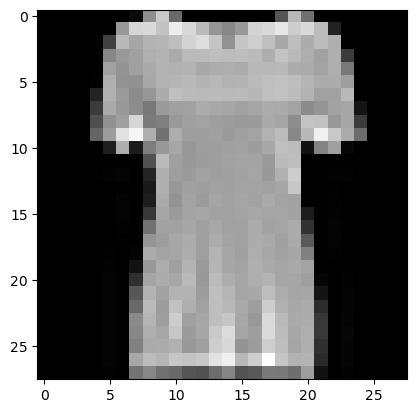

In [39]:
print(title[y_train[10]])
plt.imshow(X_train[10],cmap="gray")
plt.show()


- 데이터 전처리 : Xception 모델의 입력 데이터 크기(244,244,3)
    - 28x28 이미지를 244x244 크기로 확대
    - 색상 차원을 추가(reshape())
    - 3차원으로 변환 - 똑같은 데이터를 복사해서 3차원으로 만듬
    - 라벨 원핫인코딩

In [40]:
# 이미지확대
from PIL import Image

train_resize = []
# 이미지 하나씩 읽어오기
for i in range(len(X_train)):
    # 배열을 이미지 타입으로 변환
    img = Image.fromarray(X_train[i])

    # 이미지 크기를 변경
    img = img.resize((244,244))
    
    # 변경한 이미지들을 배열로 변환해서 리스트에 저장
    train_resize.append(np.array(img))

#이미지를 배열로 변환
X_train_resize = np.array(train_resize)

test_resize = []

for i in range(len(X_test)):
    img = Image.fromarray(X_test[i])
    img = img.resize((244,244))
    test_resize.append(np.array(img))

X_test_resize = np.array(test_resize)


In [41]:
X_train_resize.shape,X_test_resize.shape

((1000, 244, 244), (500, 244, 244))

In [42]:
# 색상 차원 추가
X_train_resize = X_train_resize.reshape(-1,244,244,1)
X_test_resize = X_test_resize.reshape(-1,244,244,1)
X_train_resize.shape,X_test_resize.shape

((1000, 244, 244, 1), (500, 244, 244, 1))

In [43]:
# 컬러 이미지로 변경
# 동일한 데이터를 3번 복사, axis=3 : 3번 인덱스에 차원 추가
X_train_resize = np.repeat(X_train_resize,3,axis=3)
X_test_resize = np.repeat(X_test_resize,3,axis=3)

X_train_resize.shape,X_test_resize.shape

((1000, 244, 244, 3), (500, 244, 244, 3))

In [44]:
y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

In [45]:
y_train_en.shape,y_test_en.shape

((1000, 10), (500, 10))

- CNN+Dense로 구성된 신경망으로 학습
- 베스트 모델 저장, 학습중단, 베스트모델로 예측

In [49]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
filename = "./model/bs_fashion_{epoch:03d}_{loss:.3f}_{val_loss:.3f}.keras"
mc = ModelCheckpoint(filepath=filename,monitor="val_loss",save_best_only=True)
es = EarlyStopping(monitor="val_loss", patience=5)

In [54]:
m5 = Sequential()
m5.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",
              input_shape=(244,244,3)))
m5.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
m5.add(MaxPooling2D(pool_size=(2,2)))
m5.add(Conv2D(filters=64, kernel_size=(3,3)))
m5.add(Conv2D(filters=64, kernel_size=(3,3)))
m5.add(MaxPooling2D())
m5.add(Conv2D(filters=128, kernel_size=(3,3)))
m5.add(Conv2D(filters=128, kernel_size=(3,3)))
m5.add(MaxPooling2D())

m5.add(Flatten())
m5.add(Dense(units=128, activation="relu"))
m5.add(Dense(units=10, activation="softmax"))
m5.summary()

c:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 240, 240, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 118, 118, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 116, 116, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 54, 54, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │    11,944,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,232,362 (46.66 MB)

 Trainable params: 12,232,362 (46.66 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
m5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
h5 = m5.fit(X_train_resize,y_train_en,epochs=10,validation_split=0.2,callbacks=[mc,es])

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.1941 - loss: 1009.5115 - val_accuracy: 0.4700 - val_loss: 16.9909
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4470 - loss: 10.9362 - val_accuracy: 0.4950 - val_loss: 1.5931
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5587 - loss: 1.3608 - val_accuracy: 0.6850 - val_loss: 1.1416
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6582 - loss: 1.0360 - val_accuracy: 0.7050 - val_loss: 0.9644
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7452 - loss: 0.7844 - val_accuracy: 0.7350 - val_loss: 0.8298


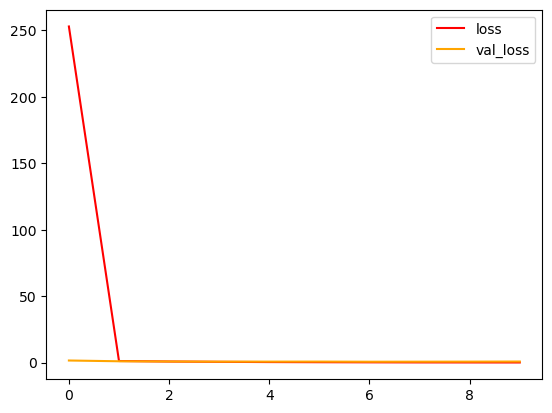

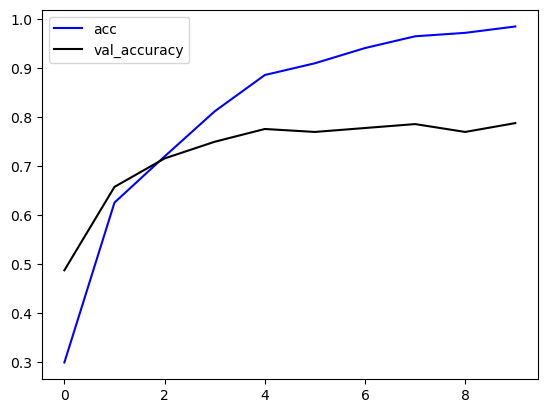

In [53]:
plt.plot(h5.history["loss"],color='r',label="loss")
plt.plot(h5.history["val_loss"],color="orange",label="val_loss")
plt.legend()
plt.show()
plt.plot(h5.history["accuracy"],color='b',label="acc")
plt.plot(h5.history["val_accuracy"],color="black",label="val_accuracy")
plt.legend()
plt.show()

In [56]:
from keras.models import load_model

bs_model = load_model("./model/bs_fashion_007_0.205_0.651.keras")

In [ ]:
idx = 100

pred = bs_model.predict(X_test_resize[idx])
print(pred)
print("예측값 : ",np.argmax(pred))
print("실제값 : ",y_test[idx])

In [ ]:
pred = bs_model.predict(X_test_resize)
for i in range(len(pred)):
    if pred[i].argmax() != y_test[i]:
        print(i, pred[i].argmax(), y_test[i])

In [61]:
m6 = Sequential()
m6.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",
              input_shape=(244,244,3)))
m6.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
m6.add(MaxPooling2D(pool_size=(2,2)))
m6.add(Dropout(0.2))
m6.add(Conv2D(filters=64, kernel_size=(3,3)))
m6.add(Conv2D(filters=64, kernel_size=(3,3)))
m6.add(MaxPooling2D())
m6.add(Dropout(0.2))
m6.add(Conv2D(filters=128, kernel_size=(3,3)))
m6.add(Conv2D(filters=128, kernel_size=(3,3)))
m6.add(MaxPooling2D())
m6.add(Dropout(0.2))

m6.add(Flatten())
m6.add(Dense(units=64, activation="relu"))
m6.add(Dropout(0.2))
m6.add(Dense(units=32, activation="relu"))
m6.add(Dropout(0.2))
m6.add(Dense(units=10, activation="softmax"))
m6.summary()

c:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 240, 240, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 118, 118, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 116, 116, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 54, 54, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,261,450 (23.89 MB)

 Trainable params: 6,261,450 (23.89 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
m6.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
h6 = m6.fit(X_train_resize,y_train_en,epochs=10,validation_data=(X_test_resize,y_test_en))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.1096 - loss: 467.0374 - val_accuracy: 0.0800 - val_loss: 2.4253
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.1195 - loss: 2.3028 - val_accuracy: 0.0620 - val_loss: 3.4413
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1195 - loss: 2.3019 - val_accuracy: 0.0600 - val_loss: 3.5196
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1195 - loss: 2.3020 - val_accuracy: 0.0600 - val_loss: 3.5244
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1195 - loss: 2.3017 - val_accuracy: 0.0600 - val_loss: 3.5255
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1219 - loss: 2.3053 - val_accuracy: 0.0540 - val_loss: 2.4424
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1195 - loss: 2.3010 - val_accuracy: 0.0720 - val_loss: 2.3581
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.1195 - loss: 2.3003 - val_accuracy: 0.0720 - val_los

In [ ]:
plt.plot(h6.history["loss"],color='r',label="loss")
plt.plot(h6.history["val_loss"],color="orange",label="val_loss")
plt.legend()
plt.show()
plt.plot(h6.history["accuracy"],color='b',label="acc")
plt.plot(h6.history["val_accuracy"],color="black",label="val_accuracy")
plt.legend()
plt.show()

In [65]:
m7 = Sequential()
m7.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(244,244,3)))
m7.add(Conv2D(filters=32, kernel_size=(3,3)))
m7.add(BatchNormalization())
m7.add(LeakyReLU())


m7.add(Conv2D(filters=64, kernel_size=(3,3)))
m7.add(BatchNormalization())
m7.add(LeakyReLU())
m7.add(Conv2D(filters=64, kernel_size=(3,3)))
m7.add(BatchNormalization())
m7.add(LeakyReLU())


m7.add(Conv2D(filters=128, kernel_size=(3,3)))
m7.add(BatchNormalization())
m7.add(LeakyReLU())
m7.add(Conv2D(filters=128, kernel_size=(3,3)))
m7.add(BatchNormalization())
m7.add(LeakyReLU())
m7.add(GlobalAveragePooling2D())

m7.add(Dense(units=10, activation="softmax"))
m7.summary()

c:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 240, 240, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 240, 240, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 240, 240, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 238, 238, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 238, 238, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 238, 238, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 236, 236, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 236, 236, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 236, 236, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 234, 234, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 234, 234, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 234, 234, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 232, 232, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 232, 232, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 232, 232, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,962 (1.11 MB)

 Trainable params: 289,130 (1.10 MB)

 Non-trainable params: 832 (3.25 KB)

In [67]:
m7.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
h7 = m7.fit(X_train_resize,y_train_en,epochs=10,batch_size=32,validation_data=(X_test_resize,y_test_en))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1114s 35s/step - accuracy: 0.4138 - loss: 1.7205 - val_accuracy: 0.1700 - val_loss: 11.9209
Epoch 2/10
13/32 ━━━━━━━━━━━━━━━━━━━━ 11:30 36s/step - accuracy: 0.4500 - loss: 1.5761

KeyboardInterrupt: 

In [ ]:
conv_xception.trainable = False

In [ ]:
m8 = Sequential()
m8.add(conv_xception)
m8.add(Flatten())


m8.add(Dense(units=64, activation="relu"))
m8.Dropout(0.2)
m8.add(Dense(units=32, activation="relu"))
m8.Dropout(0.2)
m8.add(Dense(units=10, activation="softmax"))
m8.summary()